In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

path = "medina_local_pmart_pdata/future.parquet"
futures = pd.read_parquet(path=path)
'''
ZCDFA: TSM
'''
df = futures[futures['symbol'] == 'ZCDFA']
df = df.set_index('datetime').sort_index(ascending=True)
df['pct'] = df['returns']
df = df.loc['2008-01-01':]
set(futures.symbol)

{'ZCDFA', 'ZMTXA', 'ZQFFA', 'ZTXA'}

In [9]:
def _return_days_of_extreme(df, rolling, multiplier, n_days):
    df['rolling_pct_mean'] = df['pct'].rolling(window=rolling).mean()
    df['rolling_pct_std'] = df['pct'].rolling(window=rolling).std()
    df['2std_upper'] = df['rolling_pct_mean'] + multiplier * df['rolling_pct_std']
    df['2std_lower'] = df['rolling_pct_mean'] - multiplier * df['rolling_pct_std']
     
    df[f"preparation_{n_days}d"] = df['2std_upper'] * n_days
    df['predicted_extreme_pct'] = df['pct'].rolling(5).sum().shift(-5)
    df[f'diff_predicted_extreme_pct_vs_preparation'] = df['predicted_extreme_pct'] - df[f'preparation_{n_days}d']
    
    # print("length of price shift over margin rate: ", len(df[df[f'diff_prepare{n_days}d_nextday'] < 0]), "days")
    # print(f"length of margin rate over 50%: {len(df[df['ratio_checker'] == True].index)}")
    
    outcome = len(df[df[f'diff_predicted_extreme_pct_vs_preparation'] > 0])
    return outcome

def _return_rate_overspent(df, rolling, multiplier, n_days, overspent=False):
    df['rolling_pct_mean'] = df['pct'].rolling(window=rolling).mean()
    df['rolling_pct_std'] = df['pct'].rolling(window=rolling).std()
    df['2std_upper'] = df['rolling_pct_mean'] + multiplier * df['rolling_pct_std']
    df['2std_lower'] = df['rolling_pct_mean'] - multiplier * df['rolling_pct_std']
    
    df[f"preparation_{n_days}d"] = df['2std_upper'] * n_days
    df['predicted_extreme_pct'] = df['pct'].rolling(5).sum().shift(-5)
    df[f'diff_preparation_pct_1'] = (df[f'preparation_{n_days}d'] - df['pct'].shift(-1))
    if overspent:
        outcome = df[df['diff_preparation_pct_1'] > 0]['diff_preparation_pct_1'].sum()
    elif not overspent:
        outcome = -df[df['diff_preparation_pct_1'] < 0]['diff_preparation_pct_1'].sum()
    return outcome

def _set_df_names(df, prepare_rate):
    df.columns.name = 'rolling_std/mean'
    df.index = prepare_rate
    df.index.name = 'prepare_rate'
    return df

In [16]:
margin_rate_table = pd.DataFrame() # margin days of price shift over margin rate
margin_rate_overspents_table = pd.DataFrame()
margin_rate_inverse_table = pd.DataFrame()
multiplier = 3 # std upper / std lower
prepare_rate = [1, 1.1, 1.2, 1.3, 1.4, 1.5] # what percentage of std to prepare for the extremes
ratio_check = 0.5 # performance evaluator
for rolling in range(20, 250, 20):
    margin_rate_list = [0.0] * len(prepare_rate)
    margin_rate_overspent_list = [0.0] * len(prepare_rate)
    margin_rate_inverse_list = [0.0] * len(prepare_rate)
    for index, n_days in enumerate(prepare_rate):
        margin_rate_overspent_list[index] = _return_rate_overspent(df, rolling, multiplier, n_days, overspent=True)
        margin_rate_inverse_list[index] = _return_rate_overspent(df, rolling, multiplier, n_days, overspent=False)
        margin_rate_list[index] = _return_days_of_extreme(df, rolling, multiplier, n_days)
    margin_rate_overspents_table[rolling] = margin_rate_overspent_list
    margin_rate_inverse_table[rolling] = margin_rate_inverse_list
    margin_rate_table[rolling] = margin_rate_list
    
margin_rate_table = _set_df_names(margin_rate_table, prepare_rate=prepare_rate)
margin_rate_overspents_table = _set_df_names(margin_rate_overspents_table, prepare_rate=prepare_rate)
margin_rate_inverse_table = _set_df_names(margin_rate_inverse_table, prepare_rate=prepare_rate)
print(f"days of price shift in 5 days over margin rate since 2008 (total: {len(df)}): ")
margin_rate_table

days of price shift in 5 days over margin rate since 2008 (total: 3526): 


rolling_std/mean,20,40,60,80,100,120,140,160,180,200,220,240
prepare_rate,,,,,,,,,,,,
1.0,389,364,349,335,344,341,336,333,337,339,332,320
1.1,334,306,283,275,283,277,270,268,267,267,257,252
1.2,288,258,243,231,232,225,218,218,216,212,200,198
1.3,239,213,204,192,191,178,184,173,170,165,165,158
1.4,203,174,170,154,151,144,146,140,139,136,130,129
1.5,179,144,142,123,118,117,117,111,110,109,106,103


days of price shift in 5 days over margin rate since 2008: 


[]

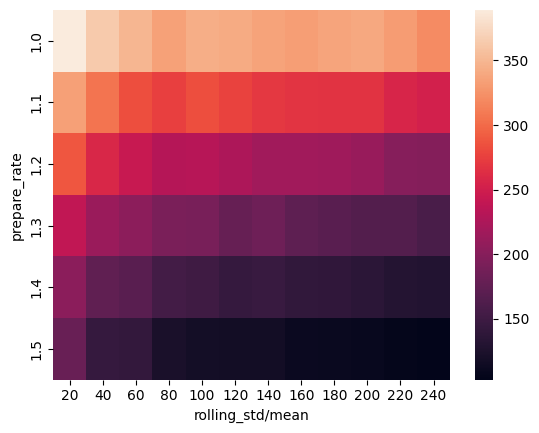

In [17]:
import seaborn as sns
print("days of price shift in 5 days over margin rate since 2008: ")
sns.heatmap(margin_rate_table, annot=False, fmt=".0f")
plt.plot() 

In [18]:
print("overspent since 2008: ")
margin_rate_overspents_table

overspent since 2008: 


rolling_std/mean,20,40,60,80,100,120,140,160,180,200,220,240
prepare_rate,,,,,,,,,,,,
1.0,146.969210,148.188104,148.039485,147.679148,146.978746,146.462000,145.815105,145.283794,144.726706,144.179623,143.717347,143.139618
1.1,161.855806,163.222513,163.075629,162.678041,161.903925,161.317886,160.616771,160.025430,159.409420,158.800950,158.283215,157.641647
1.2,176.771362,178.284206,178.141548,177.698394,176.860755,176.212106,175.450029,174.796849,174.121674,173.451946,172.877267,172.170325
1.3,191.705145,193.358923,193.217252,192.736322,191.835112,191.130911,190.307957,189.593660,188.855412,188.128946,187.494094,186.724481
1.4,206.664109,208.440404,208.305651,207.782868,206.824572,206.056486,205.174472,204.403311,203.605158,202.817197,202.122924,201.289134
1.5,221.637156,223.533740,223.399243,222.842532,221.821181,220.987369,220.046854,219.216766,218.359628,217.510958,216.756623,215.860211


overspent since 2008: 


[]

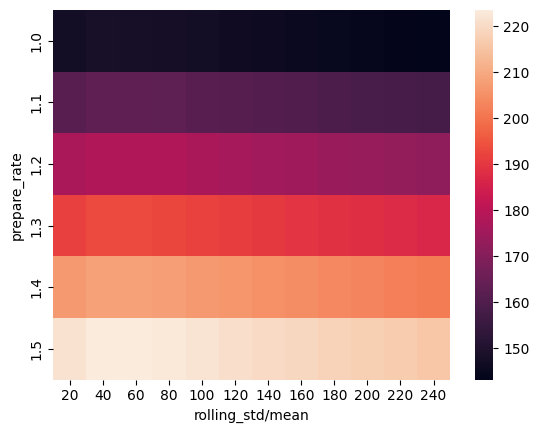

In [19]:
print("overspent since 2008: ")
sns.heatmap(margin_rate_overspents_table, annot=False, fmt=".0f") 
plt.plot()

In [20]:
print("pct_change surge over preparation_rate since 2008(sum of all diffs): ")
margin_rate_inverse_table

pct_change surge over preparation_rate since 2008(sum of all diffs): 


rolling_std/mean,20,40,60,80,100,120,140,160,180,200,220,240
prepare_rate,,,,,,,,,,,,
1.0,0.463114,0.411885,0.369879,0.373604,0.348558,0.357470,0.361547,0.378563,0.378282,0.387643,0.383567,0.395538
1.1,0.345263,0.318322,0.283011,0.285830,0.250996,0.252758,0.261371,0.274969,0.274308,0.280696,0.280893,0.290830
1.2,0.256371,0.252043,0.225917,0.219516,0.185084,0.186379,0.192787,0.201156,0.199873,0.203417,0.206403,0.212770
1.3,0.185707,0.198788,0.178609,0.170777,0.136699,0.144587,0.148873,0.152736,0.146923,0.152144,0.154689,0.160189
1.4,0.140222,0.152297,0.143996,0.130657,0.103418,0.109564,0.113547,0.117155,0.109980,0.112121,0.114977,0.118105
1.5,0.108822,0.117662,0.114576,0.103653,0.077285,0.079848,0.084087,0.085379,0.077761,0.077607,0.080134,0.082444


inverse since 2008: 


[]

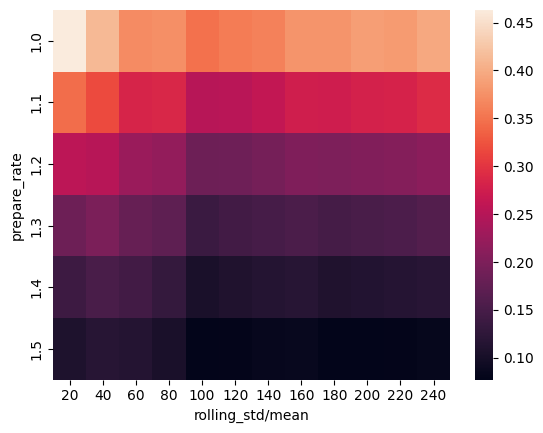

In [21]:
print("inverse since 2008: ")
sns.heatmap(margin_rate_inverse_table, annot=False, fmt=".0f") 
plt.plot()